## Import necessary libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

## Load the dataset

In [19]:
df = pd.read_csv('train.csv')

## Display basic information

In [20]:

print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (614, 13)

Missing Values:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


## Data Visualization

## # 1. Loan Status Distribution

Text(0.5, 1.0, 'Loan Approval Distribution')

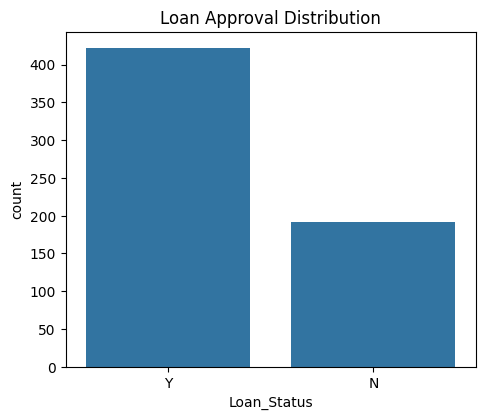

In [21]:
plt.figure(figsize=(18, 20))

# Create 4x3 grid for 12 subplots

plt.subplot(4, 3, 1)
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Approval Distribution')

## 2. Categorical Features Analysis

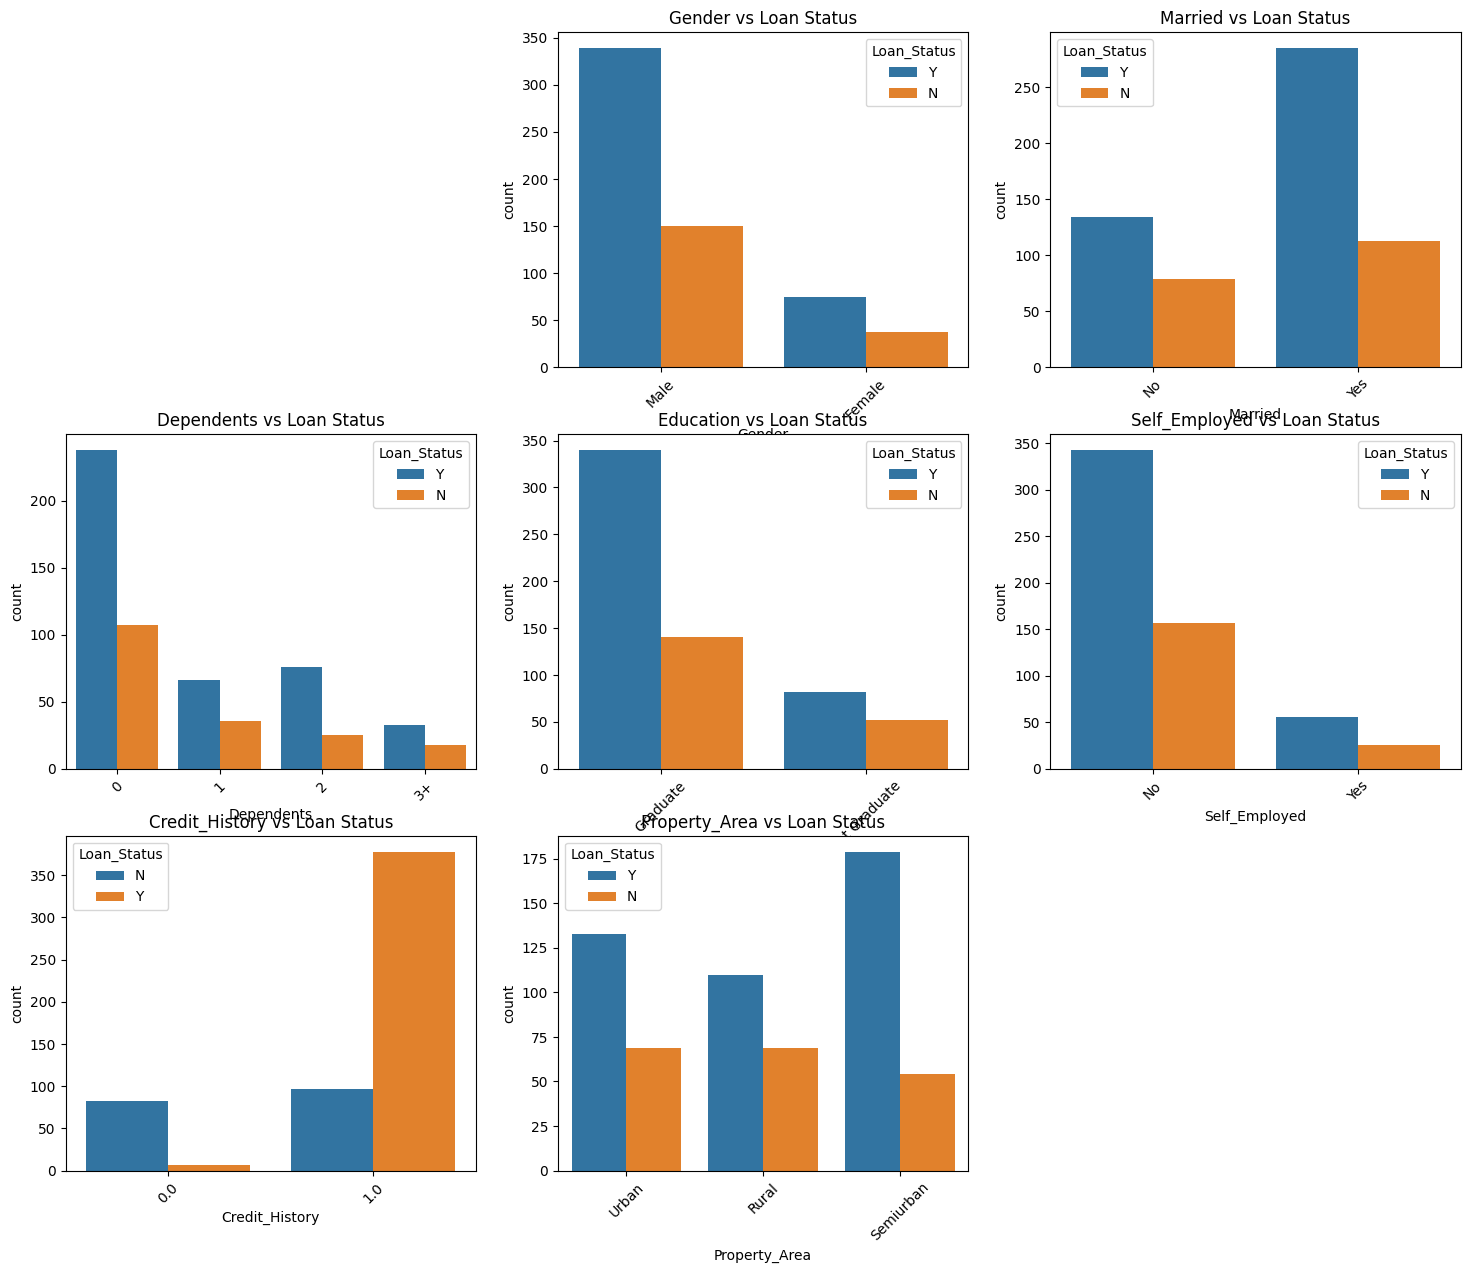

In [23]:
plt.figure(figsize=(18, 20))
cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
           'Self_Employed', 'Credit_History', 'Property_Area']
for i, col in enumerate(cat_cols, 2):
    plt.subplot(4, 3, i)
    sns.countplot(x=col, hue='Loan_Status', data=df)
    plt.title(f'{col} vs Loan Status')
    plt.xticks(rotation=45)

## 3. Numerical Features Analysis

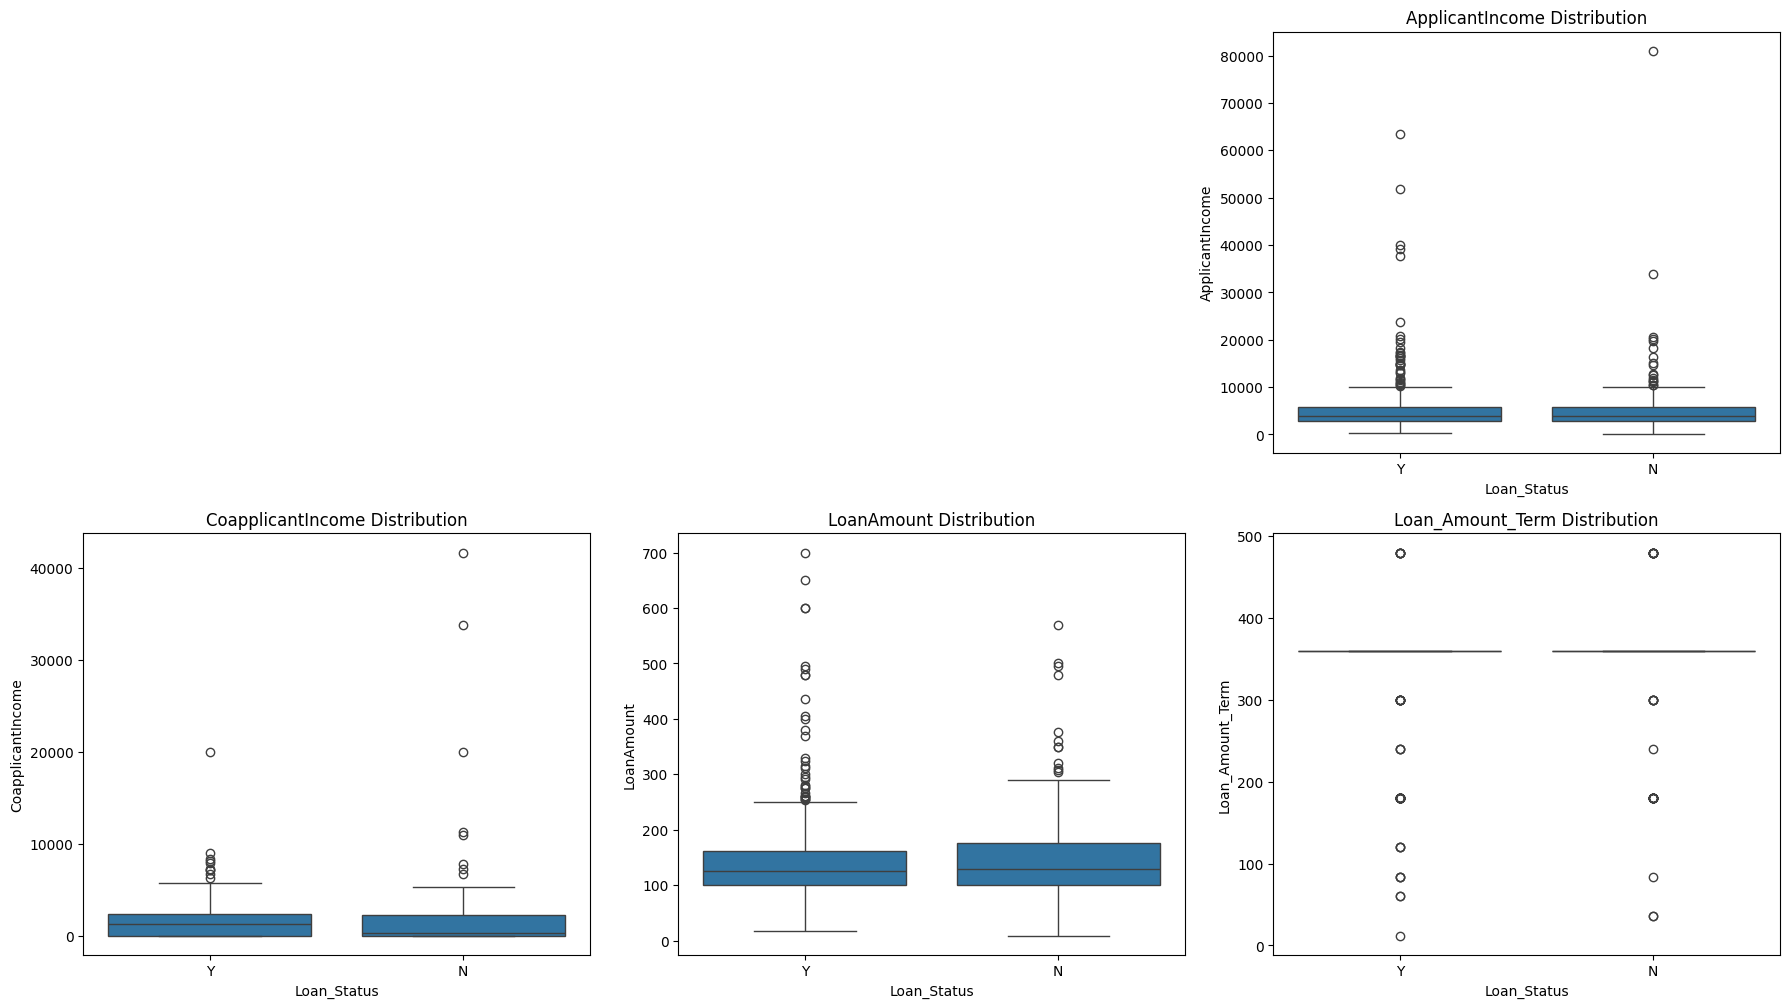

In [24]:
plt.figure(figsize=(18, 20))
num_cols = ['ApplicantIncome', 'CoapplicantIncome',
           'LoanAmount', 'Loan_Amount_Term']
for i, col in enumerate(num_cols, 9):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Loan_Status', y=col, data=df)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [25]:
# Handle missing values
# Convert 'Dependents' 3+ to 3
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(float)

# Numerical columns imputation
num_imputer = SimpleImputer(strategy='median')
num_cols_impute = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
df[num_cols_impute] = num_imputer.fit_transform(df[num_cols_impute])

# Categorical columns imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols_impute = ['Gender', 'Dependents', 'Married', 'Self_Employed']
df[cat_cols_impute] = cat_imputer.fit_transform(df[cat_cols_impute])

## Feature Engineering

In [26]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term'].replace(0, np.nan)
df['Income_to_EMI'] = df['Total_Income'] / df['EMI'].replace(0, np.nan)

# Handle infinite values and NaNs only in numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

## Convert categorical columns

In [27]:
df = pd.get_dummies(df, columns=['Gender', 'Married', 'Education',
                                'Self_Employed', 'Property_Area'],
                   drop_first=True)

In [28]:
# Encode target variable
le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

# Prepare features and target
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

## Split dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Training

In [30]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'report': classification_report(y_test, y_pred)
    }

# Model Evaluation
print("\nModel Performance Comparison:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"ROC AUC: {metrics['roc_auc']:.2f}")
    print("Classification Report:")
    print(metrics['report'])

# Feature Importance for Random Forest
rf = models['Random Forest']
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)



Model Performance Comparison:

Logistic Regression:
Accuracy: 0.85
ROC AUC: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.87      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185


Random Forest:
Accuracy: 0.83
ROC AUC: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        58
           1       0.86      0.90      0.88       127

    accuracy                           0.83       185
   macro avg       0.80      0.79      0.79       185
weighted avg       0.82      0.83      0.82       185



## Top 10 Important Features

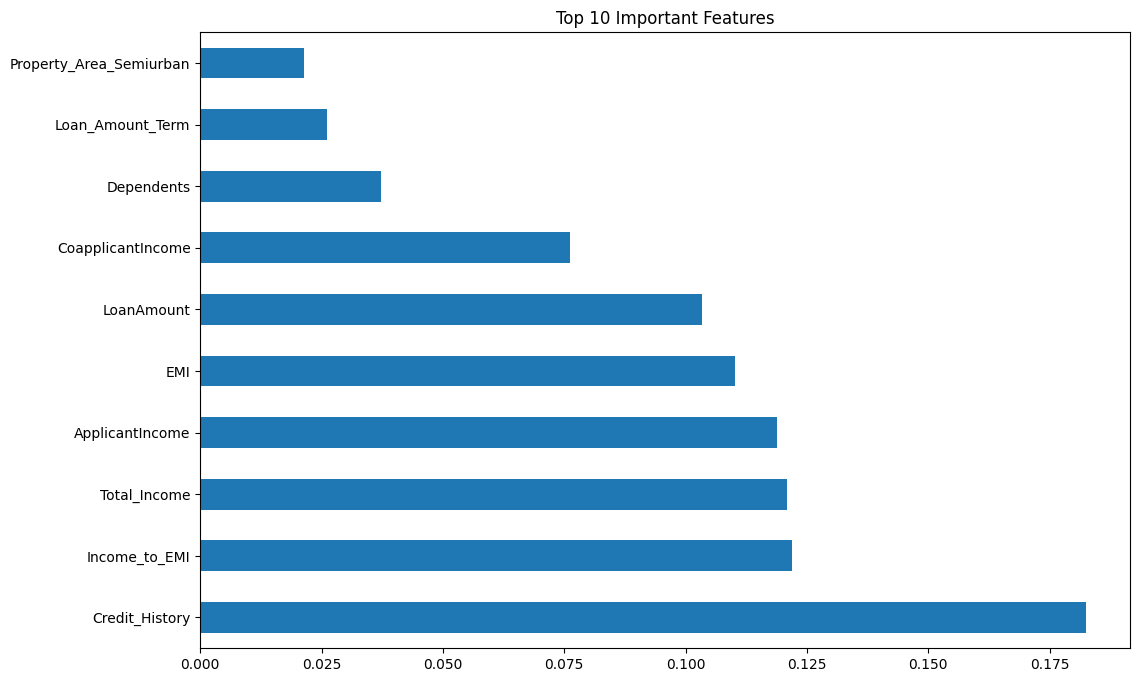

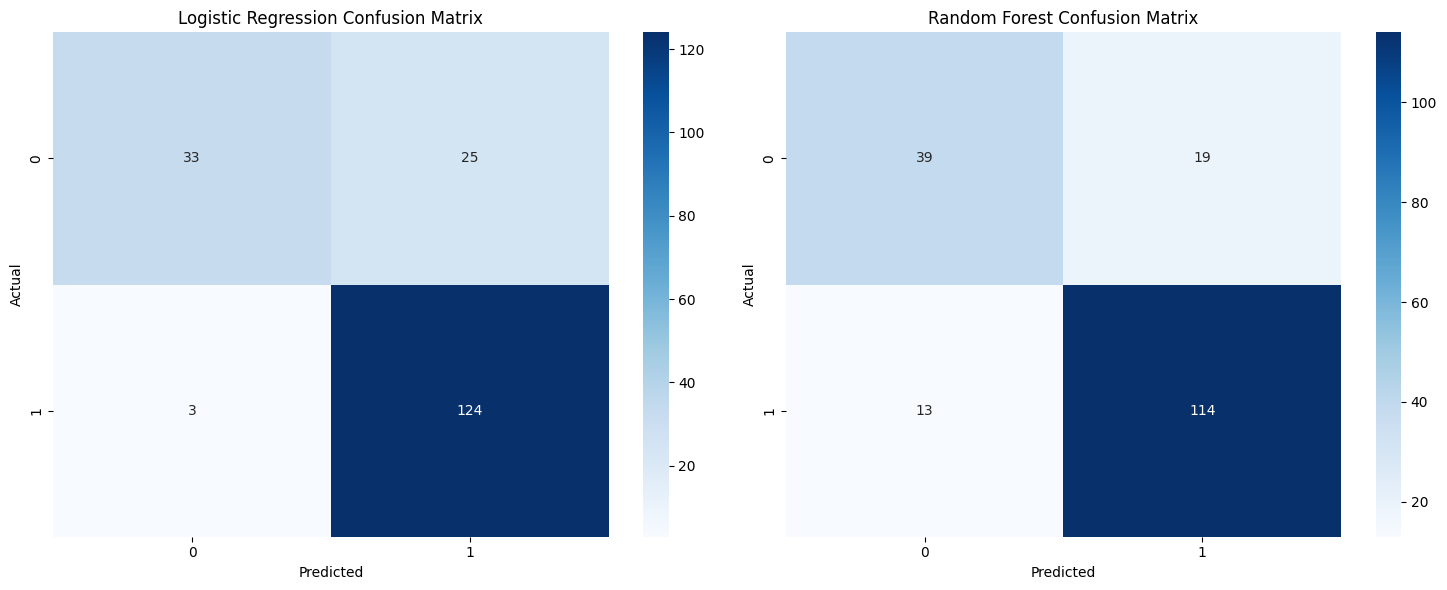

In [31]:
plt.figure(figsize=(12, 8))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()



## Confusion Matrix Visualization

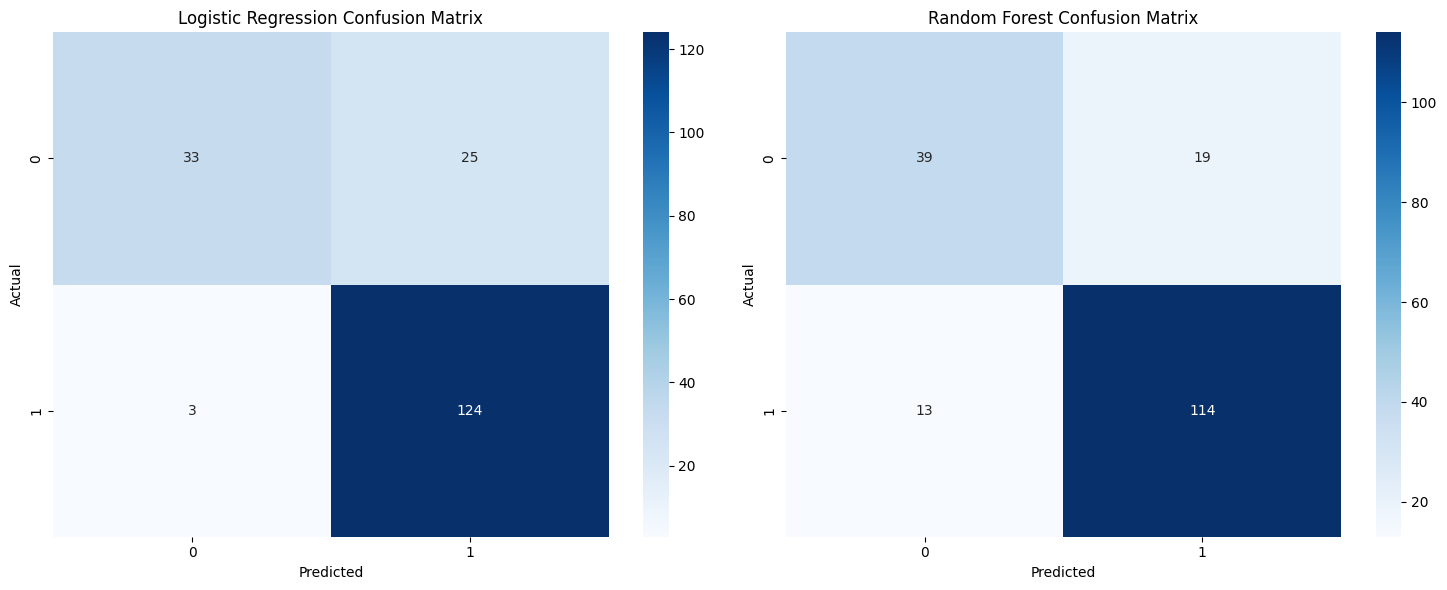

In [32]:
plt.figure(figsize=(15, 6))
for i, (name, metrics) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [33]:
# Test with sample data
sample_data = {
    'Loan_ID': ['LP001005'],
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': ['1'],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'ApplicantIncome': [4583],
    'CoapplicantIncome': [1508],
    'LoanAmount': [128],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],
    'Property_Area': ['Urban']
}

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data)

# Preprocessing pipeline for new data
def preprocess_new_data(new_df, num_imputer, cat_imputer, scaler, le):
    # Store Loan_ID for reference
    loan_ids = new_df['Loan_ID']

    # Replicate all preprocessing steps
    # Convert Dependents 3+ to 3
    new_df['Dependents'] = new_df['Dependents'].replace('3+', '3').astype(float)

    # Impute numerical features
    new_df[num_cols_impute] = num_imputer.transform(new_df[num_cols_impute])

    # Impute categorical features
    new_df[cat_cols_impute] = cat_imputer.transform(new_df[cat_cols_impute])

    # Feature engineering
    new_df['Total_Income'] = new_df['ApplicantIncome'] + new_df['CoapplicantIncome']
    new_df['EMI'] = new_df['LoanAmount'] / new_df['Loan_Amount_Term'].replace(0, np.nan)
    new_df['Income_to_EMI'] = new_df['Total_Income'] / new_df['EMI'].replace(0, np.nan)

    # Handle infinite/NaN values
    numeric_cols = new_df.select_dtypes(include=[np.number]).columns
    new_df[numeric_cols] = new_df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    new_df[numeric_cols] = new_df[numeric_cols].fillna(new_df[numeric_cols].median())

    # Create dummy variables
    new_df = pd.get_dummies(new_df, columns=['Gender', 'Married', 'Education',
                                           'Self_Employed', 'Property_Area'],
                          drop_first=True)

    # Align columns with training data
    missing_cols = set(X.columns) - set(new_df.columns)
    for col in missing_cols:
        new_df[col] = 0

    extra_cols = set(new_df.columns) - set(X.columns)
    new_df = new_df[X.columns]

    # Feature scaling
    new_df_scaled = scaler.transform(new_df)

    return loan_ids, new_df_scaled

# Preprocess the sample data
loan_ids, processed_sample = preprocess_new_data(sample_df.copy(), num_imputer, cat_imputer, scaler, le)

# Make predictions
rf_model = models['Random Forest']
predictions = rf_model.predict(processed_sample)
pred_prob = rf_model.predict_proba(processed_sample)[:, 1]

# Decode predictions
prediction_labels = le.inverse_transform(predictions)

# Display results
print("\nSample Data Prediction Results:")
for loan_id, pred, prob in zip(loan_ids, prediction_labels, pred_prob):
    print(f"\nLoan ID: {loan_id}")
    print(f"Prediction: {pred}")
    print(f"Approval Probability: {prob:.2%}")
    print(f"Confidence Level: {'High' if prob > 0.7 else 'Medium' if prob > 0.5 else 'Low'}")


Sample Data Prediction Results:

Loan ID: LP001005
Prediction: Y
Approval Probability: 56.00%
Confidence Level: Medium
